In [45]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import os

from functions_D3D import fetch_and_save_alplakes_data, plot_alplakes_temperature_velocity


to do

make the code easily changeable to other lakes, days, depth etc

plot temperature time series at different x,y,z
plot temperature heatmap at x,y
plot transect

In [40]:
def generate_output_path(api_url, base_dir='../data/Joux'):
    from urllib.parse import urlparse
    
    parsed_url = urlparse(api_url)
    path_parts = parsed_url.path.strip('/').split('/')
    
    # Extract components
    lake_name = path_parts[3]
    timestamp = path_parts[4]
    model = path_parts[2]
    depth = path_parts[5]

    
    # Map model names to abbreviations
    model_mapping = {
        'delft3d-flow': 'D3D',
        'delft3d': 'D3D',
        # Add more mappings as needed
    }
    
    model_abbrev = model_mapping.get(model, model.upper())
    
    return f'{base_dir}/{lake_name}_{timestamp}__{depth}m_{model_abbrev}.json'



In [41]:
def fetch_and_save_alplakes_data(api_url, verbose=True):
    """
    Fetch data from Alplakes API and save to JSON file.
    
    Parameters:
    -----------
    api_url : str
        The API URL to fetch data from
    verbose : bool, optional
        Whether to print progress messages (default: True)
    
    Returns:
    --------
    dict or None
        The fetched data if successful, None otherwise
    """
    output_file = generate_output_path(api_url)
    
    if verbose:
        print(f"Output file: {output_file}")
        print("Fetching data from API...")
    
    try:
        response = requests.get(api_url, timeout=30)
        
        # Check if request was successful
        if response.status_code == 200:
            if verbose:
                print("✓ Data fetched successfully!")
                print(f"  Response length: {len(response.text)} characters")
            
            # The response is JSON formatted, parse it
            data = json.loads(response.text)
            
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            
            # Save to JSON file
            with open(output_file, 'w') as f:
                json.dump(data, f, indent=2)
            
            if verbose:
                print(f"✓ Data saved to: {output_file}")
                
                # Print some basic info about the data
                print(f"\nData summary:")
                print(f"  Time: {data.get('time', 'N/A')}")
                print(f"  Depth: {data.get('depth', {}).get('data', 'N/A')} m")
                print(f"  Variables: {list(data.get('variables', {}).keys())}")
            
            return data
            
        else:
            if verbose:
                print(f"✗ Error: {response.status_code}")
                print(response.text)
            return None
            
    except requests.exceptions.RequestException as e:
        if verbose:
            print(f"✗ Network error: {e}")
            print("\nThis script needs to be run on your local machine with internet access.")
        return None


# Usage
# api_url = "https://alplakes-api.eawag.ch/simulations/layer/delft3d-flow/joux/202304050300/1?variables=temperature&variables=velocity"
# data = fetch_and_save_alplakes_data(api_url)

In [42]:
def plot_alplakes_temperature_velocity(data, grid_size=50, skip=5, figsize=(16, 12), 
                                       save_path=None, dpi=300):
    """
    Create a temperature map with velocity arrows from Alplakes data.
    
    Parameters:
    -----------
    data : dict
        The JSON data from Alplakes API
    grid_size : int, optional
        Resolution of the interpolation grid (default: 50)
    skip : int, optional
        Subsample velocity arrows - plot every nth point (default: 5)
    figsize : tuple, optional
        Figure size in inches (default: (16, 12))
    save_path : str, optional
        Path to save the figure. If None, figure is not saved (default: None)
    dpi : int, optional
        Resolution for saved figure (default: 300)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Extract velocity data
    u_velocity = np.array(data['variables']['u']['data'], dtype=float)
    v_velocity = np.array(data['variables']['v']['data'], dtype=float)
    
    # Extract data arrays
    lat = np.array(data['lat'], dtype=float)
    lng = np.array(data['lng'], dtype=float)
    temp = np.array(data['variables']['temperature']['data'], dtype=float)
    depth = data['depth']['data']
    time_str = data['time']
    
    print(f"✓ Data loaded successfully!")
    print(f"  Time: {time_str}")
    print(f"  Depth: {depth:.2f} m")
    print(f"  Grid shape: {temp.shape}")
    print(f"  Temperature range: {np.nanmin(temp):.2f}°C to {np.nanmax(temp):.2f}°C")
    
    # Create the temperature map
    fig, ax = plt.subplots(figsize=figsize)
    
    # Flatten the arrays and remove NaN values
    lat_flat = lat.flatten()
    lng_flat = lng.flatten()
    temp_flat = temp.flatten()
    
    # Create mask for valid (non-NaN) values
    valid_mask = ~(np.isnan(lat_flat) | np.isnan(lng_flat) | np.isnan(temp_flat))
    
    # Filter to valid points only
    lat_valid = lat_flat[valid_mask]
    lng_valid = lng_flat[valid_mask]
    temp_valid = temp_flat[valid_mask]
    
    print(f"  Valid data points: {len(temp_valid)} out of {len(temp_flat)}")
    
    # Create a regular grid for interpolation
    from scipy.interpolate import griddata
    
    # Define grid resolution
    grid_lng = np.linspace(lng_valid.min(), lng_valid.max(), grid_size)
    grid_lat = np.linspace(lat_valid.min(), lat_valid.max(), grid_size)
    grid_lng, grid_lat = np.meshgrid(grid_lng, grid_lat)
    
    # Interpolate temperature values onto regular grid
    grid_temp = griddata((lng_valid, lat_valid), temp_valid, 
                         (grid_lng, grid_lat), method='cubic')
    
    # Create heatmap
    im = ax.contourf(grid_lng, grid_lat, grid_temp, 
                     levels=100,  # Number of contour levels
                     cmap='RdYlBu_r',  # Red=warm, Blue=cold
                     extend='both')
    
    # Add velocity quivers
    u_flat = u_velocity.flatten()
    v_flat = v_velocity.flatten()
    
    # Create mask for valid velocity values
    valid_vel_mask = ~(np.isnan(lat_flat) | np.isnan(lng_flat) | 
                       np.isnan(u_flat) | np.isnan(v_flat))
    
    lat_vel = lat_flat[valid_vel_mask]
    lng_vel = lng_flat[valid_vel_mask]
    u_vel = u_flat[valid_vel_mask]
    v_vel = v_flat[valid_vel_mask]
    
    # Subsample for cleaner visualization
    lat_vel_sub = lat_vel[::skip]
    lng_vel_sub = lng_vel[::skip]
    u_vel_sub = u_vel[::skip]
    v_vel_sub = v_vel[::skip]
    
    # Add quiver plot
    quiver = ax.quiver(lng_vel_sub, lat_vel_sub, u_vel_sub, v_vel_sub,
                       color='black',  # Always black arrows
                       scale=10.0,  # Larger scale = smaller arrows
                       scale_units='xy',
                       width=0.002,  # Arrow width
                       headwidth=3,  # Arrow head width
                       headlength=4,  # Arrow head length
                       alpha=0.6)  # Transparency
    
    print(f"  Velocity arrows: {len(u_vel_sub)} displayed")
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8)
    cbar.set_label('Temperature (°C)', fontsize=13)
    
    # Labels and title
    ax.set_xlabel('Longitude', fontsize=13)
    ax.set_ylabel('Latitude', fontsize=13)
    ax.set_title(f'Lake Joux Water Temperature Map\nDepth: {depth:.2f} m | {time_str}', 
                 fontsize=15, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
    
    # Equal aspect for geographic data
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"\n✓ Map saved successfully to: {save_path}")
    
    return fig, ax


# Usage example
# api_url = "https://alplakes-api.eawag.ch/simulations/layer/delft3d-flow/joux/202304050300/1?variables=temperature&variables=velocity"
# data = fetch_and_save_alplakes_data(api_url)
# fig, ax = plot_alplakes_temperature_velocity(data, grid_size=50, skip=5)
# plt.show()

Output file: ../data/Joux/joux_202304050300__1m_D3D.json
Fetching data from API...
✓ Data fetched successfully!
  Response length: 117463 characters
✓ Data saved to: ../data/Joux/joux_202304050300__1m_D3D.json

Data summary:
  Time: 2023-04-05T03:00:16+00:00
  Depth: 1.1448124647140503 m
  Variables: ['temperature', 'u', 'v']
✓ Data loaded successfully!
  Time: 2023-04-05T03:00:16+00:00
  Depth: 1.14 m
  Grid shape: (153, 22)
  Temperature range: 5.11°C to 5.79°C
  Valid data points: 2149 out of 3366
  Velocity arrows: 987 displayed


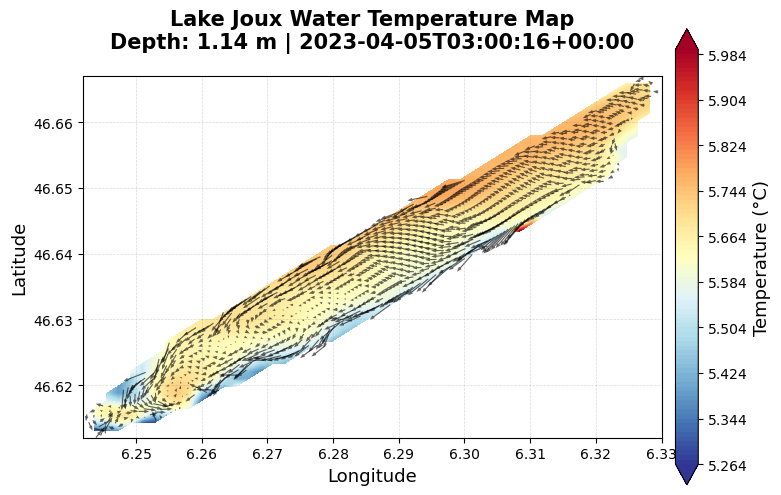

In [48]:

# Usage example
api_url = "https://alplakes-api.eawag.ch/simulations/layer/delft3d-flow/joux/202304050300/1?variables=temperature&variables=velocity"
data = fetch_and_save_alplakes_data(api_url)
fig, ax = plot_alplakes_temperature_velocity(data, grid_size=50, skip=2, figsize=(8, 6))
plt.show()